In [342]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

**Dataset**


In [343]:
data=pd.read_csv(r'C:\Users\messa\Desktop\MIV\Fouille_donn\weather.nominal.csv',header=None)

In [344]:
data.columns=['outlook','temperature','humidity','windy','play']

In [345]:
data

,outlook,temperature,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


**Support**

In [346]:
data

,outlook,temperature,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


In [347]:

def support(transactions , min_support):
  itemset=set([item for sublist in transactions for item in sublist])
  count_items={}
  for item in itemset :
    count=0
    for transaction in transactions :
      set_t=set(transaction)
      if item in transaction :
        count+=1
        
    support = count/len(transactions)
    #filter items that have support > min_support
    if min_support <= support and support!=1:
      count_items[item]=support
  count_items=pd.DataFrame.from_dict(count_items,orient='index')
  return count_items


In [348]:
import itertools

def create_itemsets(items,k):
  # items=support.index
  perm_set = itertools.combinations(items,k)
  return set(perm_set)

In [349]:
def support_itemsets(transactions , itemsets , min_support):
  count_items={}
  for item in itemsets :
    count=0
    i_set=set(item)
    for transaction in transactions :
      t_set=set(transaction)
      if t_set.intersection(i_set)==i_set :
        count+=1
    support = count/len(transactions)
    #filter items that have support > min_support
    if min_support <= support and support!=1:
       count_items[item]=support
  count_items=pd.DataFrame.from_dict(count_items,orient='index')
  return count_items

**Apriori**

In [350]:
def apriori(df,min_support):
  transactions_new = data.copy()
  for c in transactions_new .columns:
      transactions_new[c]=str(c)+"="+transactions_new[c].apply(str)
  transactions=transactions_new.to_numpy()
  item_sep=support(transactions,min_support)
  #min sup >0 a faire
  k=2
  itemset=item_sep.index
  df=pd.DataFrame()
  while len(item_sep)!=0:
    itemsets=create_itemsets(itemset,k)
    item_sep=support_itemsets(transactions,itemsets,min_support)

    if not item_sep.empty:
        itemset=list()
        for i in item_sep.index:
         for g in i:
            itemset.append(g)
        itemset=set(itemset)
    k+=1
  
  it=len(itemset)+1
  if len(itemset):
    for i in range(1,it):
      itemsets=create_itemsets(itemset,i)
      item_sep=support_itemsets(transactions,itemsets,min_support)
      df=pd.concat([item_sep,df])
    df=df.reset_index()
    df.columns=["itemsets","support"]
  else :
     print("error")

  return df,itemset


In [351]:
dk,ifreq_items=apriori(data,0.25)

In [352]:
ifreq_items

{'humidity=normal', 'play=yes', 'windy=False'}

In [353]:
l=[]
for k in dk.itemsets.to_list():
   l.append(set(k))
dk.itemsets=l

In [354]:
dk

,itemsets,support
0,"{humidity=normal, play=yes, windy=False}",0.285714
1,"{play=yes, windy=False}",0.428571
2,"{humidity=normal, windy=False}",0.285714
3,"{humidity=normal, play=yes}",0.428571
4,{play=yes},0.642857
5,{humidity=normal},0.500000
6,{windy=False},0.571429


In [355]:
ifreq_items

{'humidity=normal', 'play=yes', 'windy=False'}

In [356]:
len(dk.iloc[0].itemsets)

3

Association Rules

In [359]:
def  Association_Rules(dd,apriori_output,threshold=1,metric='confidence'):
    result=pd.DataFrame(columns=['cause','consequence','confidence','lift'])
    l=[]
    np_avant=[]
    np_apres=[]
    conf=[]
    lift=[]
    for k in range(2,len(dk.iloc[0].itemsets)+1):
        perm_set = itertools.permutations(apriori_output,k)
        for j in perm_set:
            l.append(tuple(j))
        perm=l
    print(perm)
    for p in perm:
        taille=len(p)-1
        while taille>0:
            if (dd['itemsets']==set(p)).any():
                c1=dd[dd['itemsets']==set(p)].support.values/dd[dd['itemsets']==set(p[-taille:])].support.values
                l1=float(c1)/dd[dd['itemsets']==set(p[:-taille])].support.values
                np_avant.append(set(p[-taille:]))
                np_apres.append(set(p[:-taille]))
                conf.append(c1)
                lift.append((l1))
            taille-=1
    result.cause=np_avant
    result.consequence=np_apres
    result.confidence=conf
    result.lift=lift
    if metric=="confidence":
     return result.sort_values(by="confidence")
    else:
       return result.sort_values(by="lift")


In [360]:
Association_Rules(dk,ifreq_items,threshold=1,metric='confidence').head(20)

[('humidity=normal', 'play=yes'), ('humidity=normal', 'windy=False'), ('play=yes', 'humidity=normal'), ('play=yes', 'windy=False'), ('windy=False', 'humidity=normal'), ('windy=False', 'play=yes'), ('humidity=normal', 'play=yes', 'windy=False'), ('humidity=normal', 'windy=False', 'play=yes'), ('play=yes', 'humidity=normal', 'windy=False'), ('play=yes', 'windy=False', 'humidity=normal'), ('windy=False', 'humidity=normal', 'play=yes'), ('windy=False', 'play=yes', 'humidity=normal')]


,cause,consequence,confidence,lift
15,{play=yes},"{humidity=normal, windy=False}",[0.44444444444444436],[1.5555555555555554]
9,{play=yes},"{humidity=normal, windy=False}",[0.44444444444444436],[1.5555555555555554]
1,{windy=False},{humidity=normal},[0.5],[1.0]
11,{windy=False},"{humidity=normal, play=yes}",[0.5],[1.1666666666666667]
7,{windy=False},"{humidity=normal, play=yes}",[0.5],[1.1666666666666667]
17,{humidity=normal},"{play=yes, windy=False}",[0.5714285714285714],[1.3333333333333333]
4,{humidity=normal},{windy=False},[0.5714285714285714],[1.0]
13,{humidity=normal},"{play=yes, windy=False}",[0.5714285714285714],[1.3333333333333333]
14,"{humidity=normal, play=yes}",{windy=False},[0.6666666666666666],[1.1666666666666667]
0,{play=yes},{humidity=normal},[0.6666666666666666],[1.3333333333333333]


Ameioration


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

In [ ]:
encoder=LabelEncoder()
transactions =pd.DataFrame()
for c in data.columns:
    transactions[c]=encoder.fit_transform(data[c])

In [ ]:
transactions

,outlook,temperature,humidity,windy,play
0,2,1,0,0,0
1,2,1,0,1,0
2,0,1,0,0,1
3,1,2,0,0,1
4,1,0,1,0,1
5,1,0,1,1,0
6,0,0,1,1,1
7,2,2,0,0,0
8,2,0,1,0,1
9,1,2,1,0,1


In [ ]:
import numpy as np
# turn data to numerical value
encoder=LabelEncoder()
tr =pd.DataFrame()
for c in data.columns:
    tr[c]=encoder.fit_transform(data[c])
numerical_transactions = tr.to_numpy()

In [ ]:
#choisir le best k-cluster avec elbow methode 
sum_of_squared_distances=[]
K=range(1,15)
for k in K:
    km=KMeans(n_clusters=k,n_init=5).fit(numerical_transactions)
    sum_of_squared_distances.append(km.inertia_)

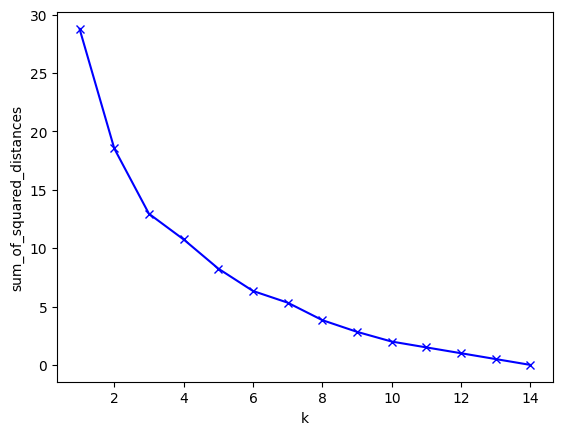

In [ ]:
plt.plot(K,sum_of_squared_distances,'bx-')
plt.xlabel('k')
plt.ylabel("sum_of_squared_distances")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=5,n_init=1, random_state=0).fit(numerical_transactions)
labels = kmeans.labels_

# Calculer la moyenne des support dans chaque cluster 
cluster_support = {}
for i in range(len(transactions)):
    if labels[i] not in cluster_support:
        cluster_support[labels[i]] = []
    cluster_support[labels[i]].append(np.mean(numerical_transactions[i]))

#utiliser le mean de tout les cluster comme meuillerur seuil
min_support = np.mean([np.mean(cluster_support[c]) for c in cluster_support])

print("Minimum support threshold:", min_support)

Minimum support threshold: 0.7100000000000001


In [ ]:


# initialize the KMeans clustering algorithm
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)

# fit the KMeans model to the data
kmeans.fit(transactions)

# compute the within-cluster sum of squares (WCSS) for each cluster
wcss_values = []
for i in range(5):
    cluster_points = transactions[kmeans.labels_ == i]
    wcss = np.sum((cluster_points - kmeans.cluster_centers_[i])**2)
    wcss_values.append(wcss)
    print(wcss_values)

# set the minimum support threshold to a value proportional to the average WCSS
minsup = float(np.sqrt(np.mean(wcss_values)) * 0.8)
minsup

[outlook        0.5
temperature    0.0
humidity       0.0
windy          0.0
play           0.5
dtype: float64]
[outlook        0.5
temperature    0.0
humidity       0.0
windy          0.0
play           0.5
dtype: float64, outlook        0.75
temperature    1.00
humidity       0.00
windy          1.00
play           0.00
dtype: float64]
[outlook        0.5
temperature    0.0
humidity       0.0
windy          0.0
play           0.5
dtype: float64, outlook        0.75
temperature    1.00
humidity       0.00
windy          1.00
play           0.00
dtype: float64, outlook        0.666667
temperature    0.000000
humidity       0.666667
windy          0.666667
play           0.000000
dtype: float64]
[outlook        0.5
temperature    0.0
humidity       0.0
windy          0.0
play           0.5
dtype: float64, outlook        0.75
temperature    1.00
humidity       0.00
windy          1.00
play           0.00
dtype: float64, outlook        0.666667
temperature    0.000000
humidity       0.666

0.4595650117230423

In [ ]:
import pandas as pd

# Define a list of candidate minimum supports
min_sup_list = [0.1, 0.05, 0.01, 0.005, 0.001]

# Evaluate performance for each candidate minimum support
best_min_sup = None
best_metric = 0
for min_sup in min_sup_list:
    # Run Apriori algorithm
    df,frequent_itemsets = apriori(transactions,min_sup)
        # Evaluate performance based on some metric (e.g. number of frequent itemsets)
    num_frequent_itemsets = len(frequent_itemsets)
    
    # Update best minimum support and metric if necessary
    if num_frequent_itemsets > best_metric:
        best_metric = num_frequent_itemsets
        best_min_sup = min_sup

# Use the best minimum support for the final Apriori run
print(best_min_sup)

0.05


0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.2
0.3
0.5


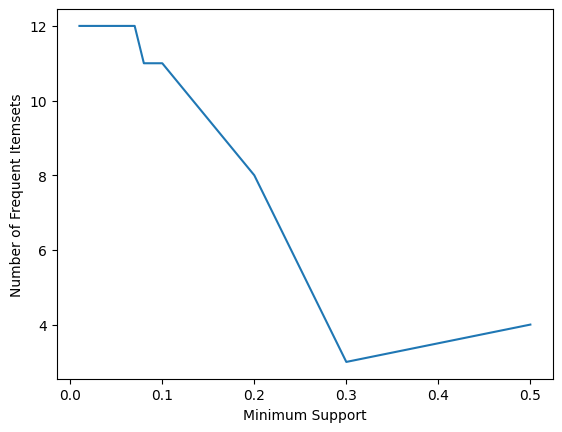

In [ ]:
min_supports = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,0.2,0.3,0.5]
num_frequent_sets = []
for suppor in min_supports:
    print(suppor)
    df,frequent_itemsets = apriori(transactions,suppor)
    num_frequent_sets.append(len(frequent_itemsets))

# Plot the number of frequent itemsets against the support values
plt.plot(min_supports, num_frequent_sets)
plt.xlabel('Minimum Support')
plt.ylabel('Number of Frequent Itemsets')
plt.show()


In [ ]:
from kneed import KneeLocator
kn = KneeLocator(min_supports, num_frequent_sets, curve='concave', direction='decreasing')
min_support = kn.knee

In [ ]:
min_support

0.5

CLOSE

In [ ]:
transactions = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans' ,'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'], 
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans','Yogurt'],
           ['corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]

In [ ]:
def support_items(transactions , min_support):
      count_items={}
      itemsets=set([item for sublist in transactions for item in sublist])
      for item in itemsets:
        itemset = frozenset([item])
        support = sum(1 for transaction in transactions if itemset.issubset(transaction)) / len(transactions)
        
        if support >= min_support:
            count_items[itemset] = support
      return  count_items

In [ ]:
def create_itemsets(closed_frequent_itemsets,k):
  itemsets = set(frozenset.union(itemset1, itemset2) for itemset1 in closed_frequent_itemsets for itemset2 in closed_frequent_itemsets if len(itemset1.union(itemset2)) == k)


  return itemsets

In [ ]:
def support_iteamset(transactions,itemsets,min_support):
        frequent_itemsets_k = {}
        taille = len(transactions)
        for itemset in itemsets:
            support = sum(1 for transaction in transactions if itemset.issubset(transaction)) / taille
            if support >= min_support:
                frequent_itemsets_k[itemset] = support
        return frequent_itemsets_k

In [ ]:
def Remove(frequent_itemsets):
   reduced ={}
   for itemset1 in frequent_itemsets:
            redundant = False
            for itemset2 in frequent_itemsets:
                if itemset1 != itemset2 and itemset1.issubset(itemset2) and frequent_itemsets[itemset1] == frequent_itemsets[itemset2]:
                    redundant = True
                    break
            if not redundant:
                reduced[itemset1] = frequent_itemsets[itemset1]
   return reduced

In [ ]:
def close(transactions, min_support):

    
    closed_frequent_itemsets = support_items(transactions , min_support)
  
    k = 2
    while True:
        itemsets = create_itemsets(closed_frequent_itemsets,k)
        if len(itemsets) == 0:
            break
        
        frequent_itemsets = support_iteamset(transactions ,itemsets, min_support)
        if len(frequent_itemsets) == 0:
            break
        
        frequent_itemsets_reduced = Remove(frequent_itemsets)


        closed_frequent_itemsets.update(frequent_itemsets_reduced)
        
        k += 1
    
    return closed_frequent_itemsets

In [ ]:
close(transactions, 0.5)

{frozenset({'Milk'}): 0.6,
 frozenset({'Kidney Beans'}): 1.0,
 frozenset({'Eggs'}): 0.8,
 frozenset({'Onion'}): 0.6,
 frozenset({'Yogurt'}): 0.6,
 frozenset({'Kidney Beans', 'Onion'}): 0.6,
 frozenset({'Eggs', 'Onion'}): 0.6,
 frozenset({'Kidney Beans', 'Yogurt'}): 0.6,
 frozenset({'Eggs', 'Kidney Beans'}): 0.8,
 frozenset({'Kidney Beans', 'Milk'}): 0.6,
 frozenset({'Eggs', 'Kidney Beans', 'Onion'}): 0.6}